In [5]:
%matplotlib inline
import math
import torch 
from torch import nn
from torch.nn import functional as F 
from d2l import torch as d2l
from sklearn.model_selection import ParameterGrid

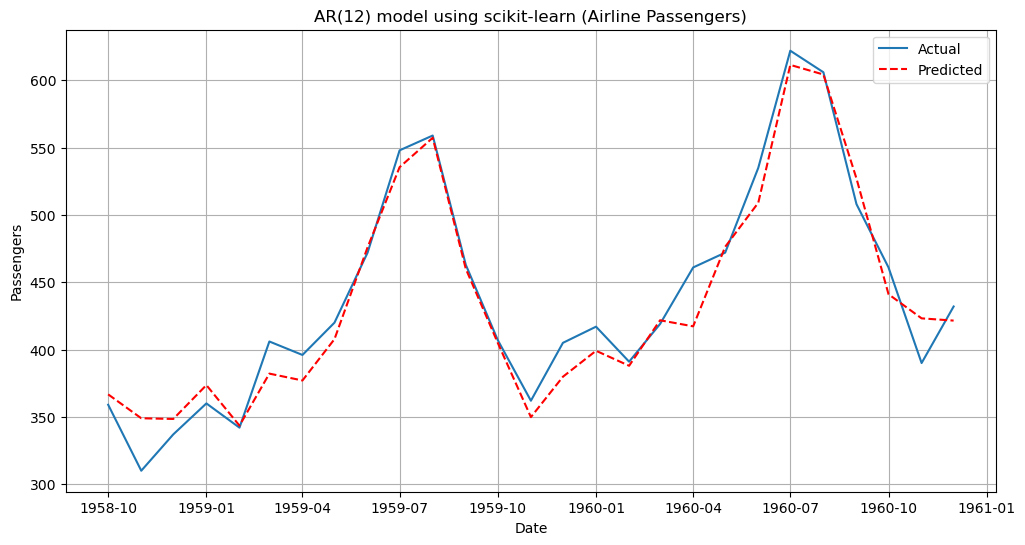

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load a time series (e.g., airline passengers dataset)
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')
ts = df['Passengers']

# Convert to supervised learning with lag=12
def create_lagged_features(series, lag=12):
    df = pd.DataFrame({'y': series})
    for i in range(1, lag+1):
        df[f'lag_{i}'] = df['y'].shift(i)
    return df.dropna()

# Create features
lag = 12
data = create_lagged_features(ts, lag)
X = data.drop(columns='y').values
y = data['y'].values

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(ts.index[-len(y_test):], y_test, label='Actual')
plt.plot(ts.index[-len(y_test):], y_pred, label='Predicted', linestyle='--', color='red')
plt.title(f'AR({lag}) model using scikit-learn (Airline Passengers)')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.grid(True)
plt.show()



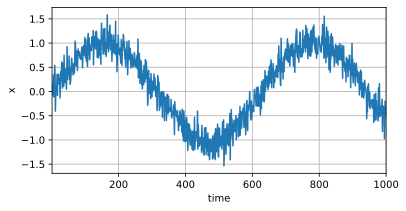

In [30]:
class Data(d2l.DataModule):
    def __init__(self,batch_size=16,T=1000,tau=4,num_train=600):
        self.save_hyperparameters()
        self.time = torch.arange(1,T+1, dtype=torch.float32)
        self.x = torch.sin(0.01*self.time) + torch.randn(T)*0.2 #adding noise in the data
data = Data()
d2l.plot(data.time,data.x,'time','x',xlim=[1,1000], figsize=(6,3))

In [32]:
@d2l.add_to_class(Data)
def get_dataloader(self,train):
    features = [self.x[i: self.T - self.tau + i] for i in range(self.tau)]
    self.features = torch.stack(features,1)
    self.labels = self.x[self.tau:].reshape(-1,1)
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.features, self.labels], train, i)

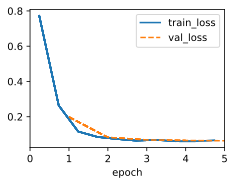

In [18]:
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model,data)

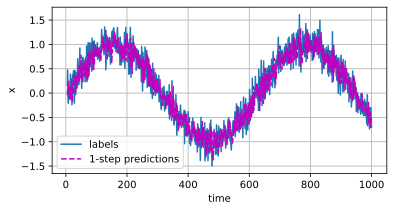

In [19]:
onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:],[data.labels,onestep_preds],"time","x",legend=['labels','1-step predictions'],figsize=(6,3))

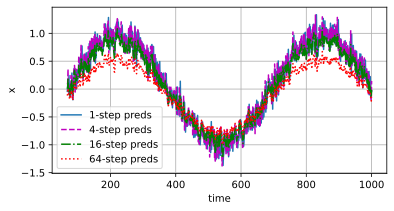

In [27]:
def k_step_preds(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i: i+data.T-data.tau-k+1])
    for i in range(k):
        preds = model(torch.stack(features[i:i+data.tau],1))
        features.append(preds.reshape(-1))
    return features[data.tau:]

steps = (1,4,16,64)
preds = k_step_preds(steps[-1])
d2l.plot(data.time[data.tau + steps[-1] -1:],
         [preds[k-1].detach().numpy() for k in steps], "time" , "x" ,
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))

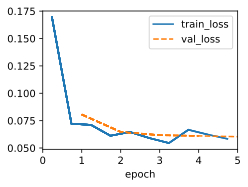

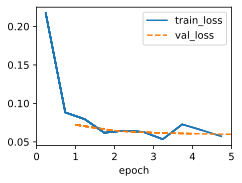

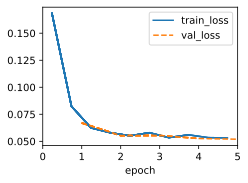

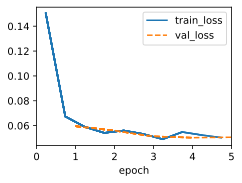

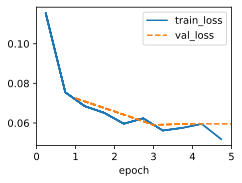

In [34]:
taus = [4,8,16,32,54]
tau_loss = []
for t in taus:
    data = Data(tau = t)
    model = d2l.LinearRegression(lr=0.01)
    trainer = d2l.Trainer(max_epochs=5)
    trainer.fit(model,data)
    onestep_preds = model(data.features[data.num_train:])
    tau_loss.append(model.loss(y_hat=onestep_preds,y=data.labels[data.num_train:))

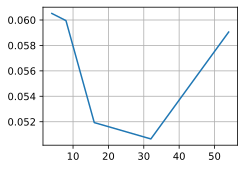

In [47]:
d2l.plot(taus,[l.item() for l in tau_loss])

In [53]:
class TauData(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.save_hyperparameters()
        self.time = torch.range(1, T, dtype=torch.float32)
        self.x = torch.sin(0.01*self.time)
        
    def get_dataloader(self, train):
        features = [self.x[i:self.T-self.tau+i] for i in range(self.tau)]
        self.features = torch.stack(features, 1)
        self.labels = self.x[self.tau:].reshape((-1, 1))
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.features, self.labels], train, i)

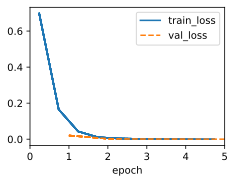

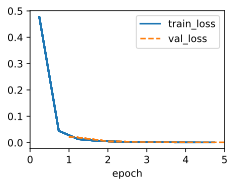

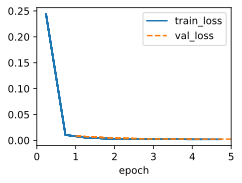

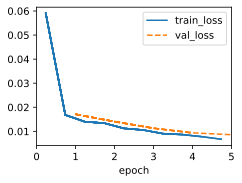

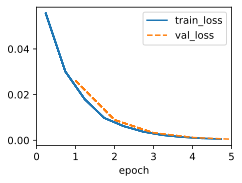

In [54]:
taus = [4,8,16,32,54]
tau_loss = []
for t in taus:
    data = TauData(tau = t)
    model = d2l.LinearRegression(lr=0.01)
    trainer = d2l.Trainer(max_epochs=5)
    trainer.fit(model,data)
    onestep_preds = model(data.features[data.num_train:])
    tau_loss.append(model.loss(y_hat=onestep_preds,y=data.labels[data.num_train:]))

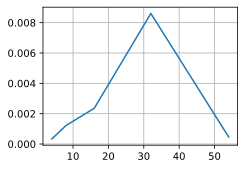

In [55]:
d2l.plot(taus,[l.item() for l in tau_loss])